## 各種 API
### numpy
各種数値計算を高速で行う(中身は C++ライブラリらしい)
公式：https://numpy.org/
ただし，日本語でもたくさん解説してくれているサイトがあるので，ググった方が早い場合もある

### pandas
行列計算，データ分析に優れたライブラリ
python 上で使う excel 的な感覚
公式：https://pandas.pydata.org/
こちらも numpy ほどではないが日本語解説が充実

### scikit-learn
データ分析，機械学習に優れたライブラリ
深層学習などと異なり，古く古典的な手法が多い(だいたいのデータ分析はこれで事足りる)
https://scikit-learn.org/stable/
numpy や pandas ほどではないが日本語解説が充実しているが，マニアックな関数は API を読むべき

### Kaggle
今回のデータの入手元: https://www.kaggle.com/c/titanic/data
タイタニックの生存者を当てる課題
今回使う test data への制度は kaggle アカウントがないとわからないので，今回は validation data への精度で代用．


### XGBoost
公式ドキュメント : https://xgboost.readthedocs.io/en/latest/python/python_api.html
勾配ブースティングの高速化実装パッケージ

### LightGBM
公式ドキュメント : https://lightgbm.readthedocs.io/en/latest/
勾配ブースティングの高速化実装パッケージ

In [ ]:
import pandas as pd
import numpy as np
from copy import deepcopy as cp
import time

from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from matplotlib import pyplot as plt
import seaborn

%matplotlib inline

## Google ドライブに接続
Google ドライブ内のファイルを使うためにはアカウント接続認証が必要

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# google ドライブのディレクトリ名を特定
import os
print(os.getcwd())
!ls /content/drive

/content
MyDrive


## 学習に使うファイルを用意
授業用フォルダの `AIP1_2020_student` フォルダ直下にある，  
- train.csv  
- test.csv  

を自分の Google ドライブの `Colab Notebooks` フォルダに保存すること．  

In [ ]:
# ファイルを読み込む
# 入手元: https://www.kaggle.com/c/titanic/data
# フォルダ名を場所によって切り替える
drive_dir_ = '/content/drive/"My Drive"/'
drive_dir = '/content/drive/My Drive/'

file_dir = 'Colab Notebooks' # 生徒が課題をやるとき(必ずマイドライブの Colab Notebooks に train.csv と test.csv に保存すること)
# file_dir = 'AIP1_2020_student' # 授業中に教師が実行するとき

train_csv = 'train.csv'
test_csv = 'test.csv'

# No such file or directory と 「出なければ」 ちゃんとファイルを認識している
!ls -l $drive_dir_"$file_dir/"$train_csv
!ls -l $drive_dir_"$file_dir/"$test_csv

-rw------- 1 root root 61194 Oct 16 05:13 '/content/drive/My Drive/Colab Notebooks/train.csv'
-rw------- 1 root root 28629 Oct 16 05:12 '/content/drive/My Drive/Colab Notebooks/test.csv'


In [ ]:
# ファイルの読み込み
origin_train_df = pd.read_csv(os.path.join(drive_dir, file_dir, train_csv))
origin_test_df = pd.read_csv(os.path.join(drive_dir, file_dir, test_csv))

## データの確認

In [ ]:
# 列名を確認
# test には Survived ＝ 生存したかどうか ＝ 教師信号が抜けていることを確認
print('train_df.columns: {}'.format(list(origin_train_df.columns)))
print('test_df.columns:  {}'.format(list(origin_test_df.columns)))

train_df.columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
test_df.columns:  ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


- PassengerID: 乗客のID（単なる通し番号），
- Survived: 生き残ったら1，そうでなければ0
- Pclass: 客室のランク（1, 2, 3の3段階で1が高級，2が中級，3が下級），
- Name: 乗客名
- Sex: 性別
- Age: 年齢
- SibSp: 乗客の同乗兄弟（あるいは配偶者）数，
- Parch: 乗客の同乗親（あるいは子）数，
- Ticket: チケット番号，
- Fare: 料金，
- Cabin: 客室番号，
- Embarked: 乗船地（C = Cherbourg, Q = Queenstown, S = Southampton）

In [ ]:
#訓練用データのデータ数、平均などの統計量を出力
origin_train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
#テスト用データのデータ数、平均などの統計量を出力
origin_test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [ ]:
#訓練用データ
origin_train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
#テスト用データ
origin_test_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# 訓練データと valid データの分割
train_df, valid_df = train_test_split(origin_train_df, test_size=0.2, random_state=0) # 乱数シードを固定して train をさらに test と valid data を 8:2 で分割

In [ ]:
# 訓練データのデータ数、平均などの統計量を出力
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,571.000000,712.000000,712.000000,712.00000
mean,443.283708,0.383427,2.317416,29.745184,0.529494,0.391854,31.86295
std,260.003783,0.486563,0.833767,14.619046,1.140842,0.821368,50.13531
min,1.000000,0.000000,1.000000,0.670000,0.000000,0.000000,0.00000
25%,211.750000,0.000000,2.000000,20.750000,0.000000,0.000000,7.91770
50%,441.000000,0.000000,3.000000,29.000000,0.000000,0.000000,14.45625
75%,671.250000,1.000000,3.000000,38.000000,1.000000,0.000000,31.27500
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


In [ ]:
# valid データのデータ数、平均などの統計量を出力
valid_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,179.000000,179.000000,179.000000,143.000000,179.000000,179.000000,179.000000
mean,456.804469,0.385475,2.273743,29.515175,0.497207,0.340782,33.561615
std,246.941313,0.488073,0.846628,14.199825,0.938408,0.742802,48.008223
min,2.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,264.000000,0.000000,1.000000,20.000000,0.000000,0.000000,7.972900
50%,485.000000,0.000000,3.000000,27.000000,0.000000,0.000000,14.000000
75%,656.500000,1.000000,3.000000,39.500000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,64.000000,5.000000,5.000000,263.000000


## データの傾向性を見る

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'fraquency')

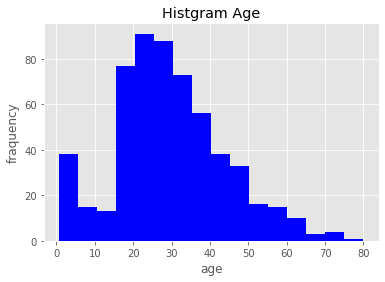

In [ ]:
# ヒストグラム
## 年齢
plt.style.use('ggplot') 
plt.hist(train_df['Age'], bins=16, color='b')
plt.title('Histgram Age')
plt.xlabel('age')
plt.ylabel('fraquency')

Text(0, 0.5, 'fraquency')

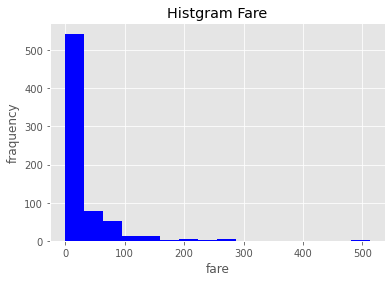

In [ ]:
# ヒストグラム
## 年齢
plt.style.use('ggplot') 
plt.hist(train_df['Fare'], bins=16, color='b')
plt.title('Histgram Fare')
plt.xlabel('fare')
plt.ylabel('fraquency')

Text(0, 0.5, 'fraquency')

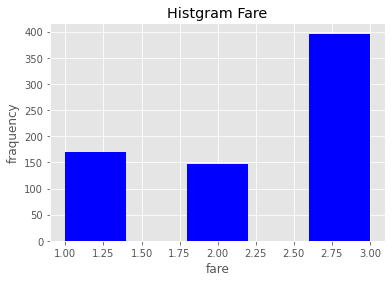

In [ ]:
# ヒストグラム
## Pclass
plt.style.use('ggplot') 
plt.hist(train_df['Pclass'], bins=5, color='b')
plt.title('Histgram Fare')
plt.xlabel('fare')
plt.ylabel('fraquency')

## データの欠損を埋める

In [ ]:
#年齢の欠損値を男女の平均年齢で補間
age_train_mean = origin_train_df.groupby('Sex').Age.mean()
 
def fage(x):
    if x.Sex == 'male':
        return round(age_train_mean['male'])
    if x.Sex == 'female':
        return round(age_train_mean['female'])
 
origin_train_df.Age.fillna(origin_train_df[origin_train_df.Age.isnull()].apply(fage,axis=1),inplace=True)

In [ ]:
#年齢の欠損値を男女の平均年齢で補間
age_test_mean = origin_test_df.groupby('Sex').Age.mean()
 
def fage(x):
    if x.Sex == 'male':
        return round(age_test_mean['male'])
    if x.Sex == 'female':
        return round(age_test_mean['female'])
 
origin_test_df.Age.fillna(origin_test_df[origin_test_df.Age.isnull()].apply(fage,axis=1),inplace=True)

## 変数の削除

In [ ]:
# 特徴量設計のために元データからコピーしておく(課題の時のため)
all_train_df = cp(origin_train_df)
test_df = cp(origin_test_df)

In [ ]:
# 授業中に利用しない変数は削除します
# all_train_df = all_train_df.drop(['Name','SibSp','Parch','Ticket','Fare','Cabin','Embarked'],axis=1)
# test_df = test_df.drop(['Name','SibSp','Parch','Ticket','Fare','Cabin','Embarked'],axis=1)

In [ ]:
# 訓練用
all_train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# テスト用
test_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 特徴量の設計

In [ ]:
#クロス集計
sex_ct = pd.crosstab(all_train_df['Sex'], all_train_df['Survived'])
sex_ct

Survived,0,1
Sex,,
female,81,233
male,468,109


In [ ]:
#Femaleカラムを追加し、Sex要素のmale/femaleを1/0に変換して、要素として追加する
# 男女に分ける
all_train_df['Female'] = all_train_df['Sex'].map( {'male': 0, 'female': 1} ).astype(int)
test_df['Female'] = test_df['Sex'].map( {'male': 0, 'female': 1} ).astype(int)
 
all_train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [ ]:
# 老人(older) を追加
all_train_df['Older'] = (all_train_df['Age']>=60).astype(int)
test_df['Older'] = (test_df['Age']>=60).astype(int)

older_ct = pd.crosstab(all_train_df['Older'], all_train_df['Survived'])
older_ct

Survived,0,1
Older,,
0,530,335
1,19,7


In [ ]:
# 子供(kid) を追加
all_train_df['Kid'] = (all_train_df['Age']<=14).astype(int)
test_df['Kid'] = (test_df['Age']<=14).astype(int)

kid_ct = pd.crosstab(all_train_df['Kid'], all_train_df['Survived'])
kid_ct

Survived,0,1
Kid,,
0,517,297
1,32,45


In [ ]:
#Pclassをダミー変数で分ける
pclass_train_df  = pd.get_dummies(all_train_df['Pclass'],prefix='Feature')
pclass_test_df  = pd.get_dummies(test_df['Pclass'],prefix='Feature')
 
pclass_train_df.head(5)

,Feature_1,Feature_2,Feature_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [ ]:
#Feature_3を削除 (他二つが 0 なら Feature_3 が　０なのは明らかであるため)
# pclass_train_df = pclass_train_df.drop(['Feature_3'], axis=1)
# pclass_test_df = pclass_test_df.drop(['Feature_3'], axis=1)
 
#Feature_1,Class_2カラムを追加
all_train_df = all_train_df.join(pclass_train_df)
test_df = test_df.join(pclass_test_df)
 
all_train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,Older,Kid,Feature_1,Feature_2,Feature_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,0,0,0,1


## 課題で再利用しやすいように[リンクテキスト](https:// [リンクテキスト](https://))データフレームを一時保存

In [ ]:
all_train_df_tmp = cp(all_train_df)
test_df_tmp = cp(test_df)

# 授業中モデルの検証


In [ ]:
# データフレームを一時保存から読み込む
all_train_df_ = cp(all_train_df_tmp)
test_df_ = cp(test_df_tmp)

## validation data に分割

In [ ]:
# 訓練データと valid データの分割
train_df, valid_df = train_test_split(all_train_df_, test_size=0.2, random_state=0) # 乱数シードを固定して train をさらに test と valid data を 8:2 で分割

## 教師信号と入力データを用意

In [ ]:
# 訓練データ準備
x_train = train_df.drop(['PassengerId','Survived','Pclass','Sex', 'Name','SibSp','Parch','Ticket','Fare','Cabin','Embarked'],axis=1) # 教師信号(Survived) 含めて必要ないデータを落とす
y_train = train_df.Survived
# Valid データ準備
x_valid = valid_df.drop(['PassengerId','Survived','Pclass','Sex', 'Name','SibSp','Parch','Ticket','Fare','Cabin','Embarked'],axis=1) # 教師信号(Survived) 含めて必要ないデータを落とす
y_valid = valid_df.Survived

## モデルの学習
### まずは　scikit-learn　での勾配ブースティング
RandomForestClassifier のドキュメント  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [ ]:
# scikit-learnのインポートをします
# 今回は勾配ブースティング
from sklearn.ensemble import GradientBoostingClassifier
 
#モデルの生成
classifier = GradientBoostingClassifier( # 以下は主なハイパーパラアメータ
    learning_rate=0.05, # 学習率
    n_estimators=100, # 木の数
    max_depth=3, # 木の最大の深さ（一番大事なパラメータ）
    # max_features=None, # 分割に使う特徴量の数：None=制限なし
    # max_leaf_nodes=None, # 末端ノード数：None=制限なし
    min_samples_leaf=1,  # 一つの葉ノードに入るデータの最小数(大きいほど細かいデータの分割を許さない)
    min_samples_split=2, # 一つの親ノードから何本枝を生やすか(何個に分割するか)
    max_features=0.7, 
    random_state=0, # シード固定みたいなもの(気にしなくて良い)
    )
# 学習用モデルをコピーして作成
model = cp(classifier)

#学習
learning_start = time.time()
model.fit(x_train, y_train)
learning_end = time.time()

## モデルの精度
### score とは？
scikit-learn の LogisticRegression は下記の accuracy と同じ  
参考：https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
参考 2: https://qiita.com/Mukomiz/items/1a87f89cea1f0bb28a63

In [ ]:
#学習したモデルの精度
print('Train score: {}'.format(model.score(x_train, y_train)))
print('Valid score: {}'.format(model.score(x_valid, y_valid)))

Train score: 0.8258426966292135
Valid score: 0.8156424581005587


## モデルの Accuracy
### Accuracy とは？
TP(真陽性): 学習器がその人物(データ)が生存と判断し，実際にデータ上生存だった数 (正解)  
FP(偽陽性): 学習器がその人物(データ)が生存と判断し，データ上では死亡だった数 (間違い)  
FN(偽陰性): 学習器がその人物(データ)が死亡と判断し，データ上では生存だった数 (間違い)  
TN(真陰性): 学習器がその人物(データ)が死亡と判断し，実際にデータ上死亡だった数 (正解)  
※この課題では生存が陽性，死亡が陰性  
  
Accuracy = (TP+TN) / (TP+FP+FN+TN)  

参考: https://data.gunosy.io/entry/2016/08/05/115345

In [ ]:
#モデルに伴う生存率の予測値
predict_y_train = model.predict(x_train)
 
#実際の値と予測値の比率
accuracy_train = accuracy_score(y_train, predict_y_train)
print('Train accyracy: {}'.format(accuracy_train))

# #モデルに伴う生存率の予測値
predict_y_valid = model.predict(x_valid)
 
#実際の値と予測値の比率
accuracy_valid = accuracy_score(y_valid, predict_y_valid)
print('Valid accyracy: {}'.format(accuracy_valid))

Train accyracy: 0.8258426966292135
Valid accyracy: 0.8156424581005587


## 決定木の構造の可視化

In [ ]:
!pip3 install pydotplus

In [ ]:
!pip3 install graphviz

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


model.estimators_.shape: (100, 1)


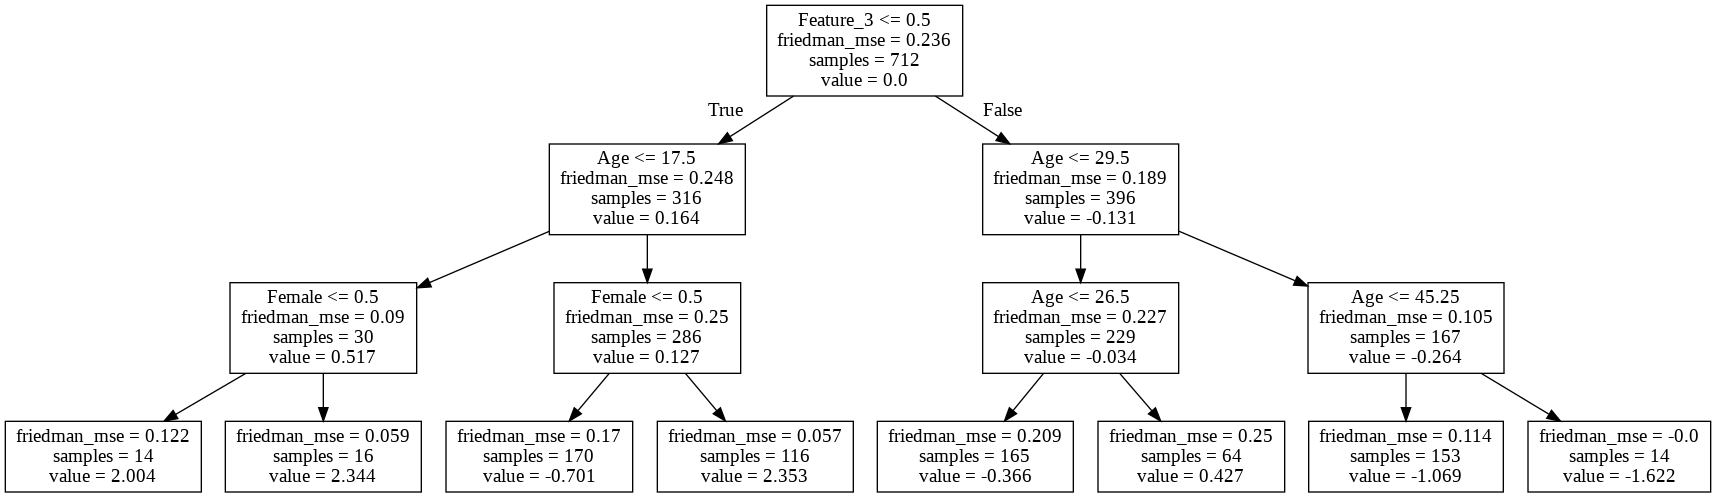

In [ ]:
#可視化
from sklearn import tree
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn.externals.six import StringIO
import seaborn as sns
from copy import deepcopy as cp

print('model.estimators_.shape: {}'.format(model.estimators_.shape))
# 表示する木の番号の指定
i = 0 
# i は RandomForestClassifier のインスタンスを作成した時に渡した変数 n_estimators の数だけ存在

dot_data = StringIO()
tree.export_graphviz(model.estimators_[i, 0], out_file=dot_data, feature_names=x_train.columns, max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf('tree_{}.pdf'.format(i))
Image(graph.create_png())

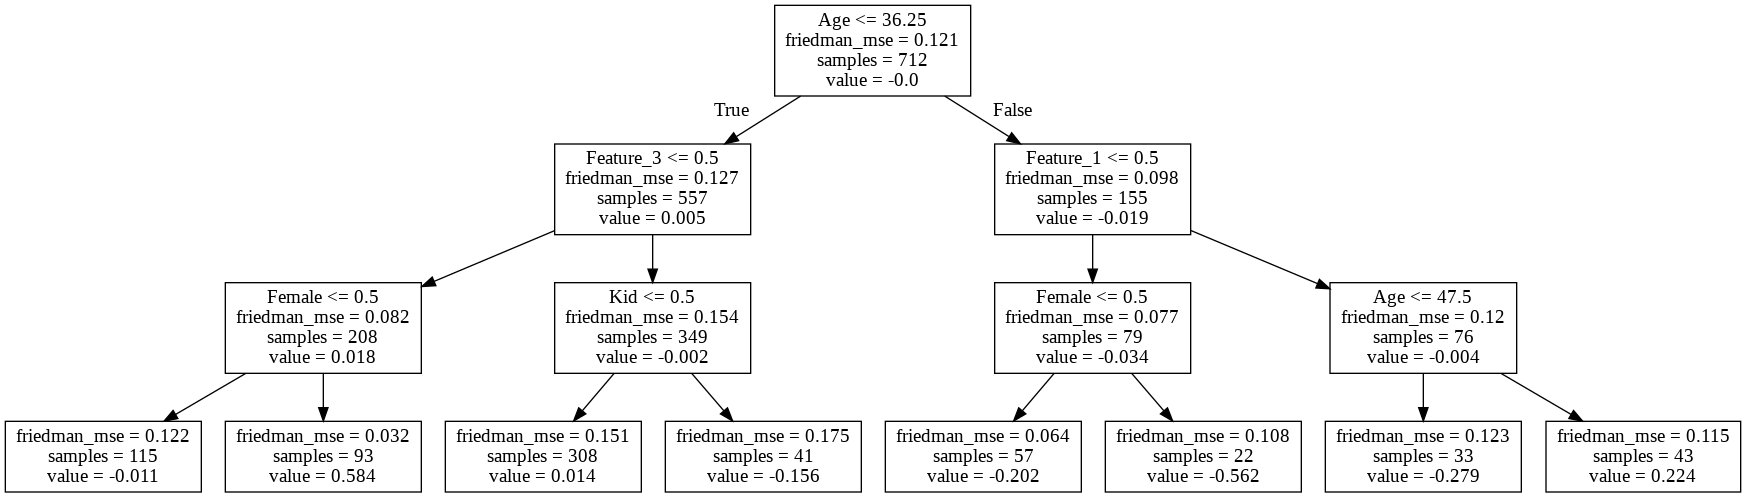

In [ ]:
# 表示する木の番号の指定
i = 99 
# i は RandomForestClassifier のインスタンスを作成した時に渡した変数 n_estimators の数だけ存在

dot_data = StringIO()
tree.export_graphviz(model.estimators_[i, 0], out_file=dot_data, feature_names=x_train.columns, max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf('tree_{}.pdf'.format(i))
Image(graph.create_png())

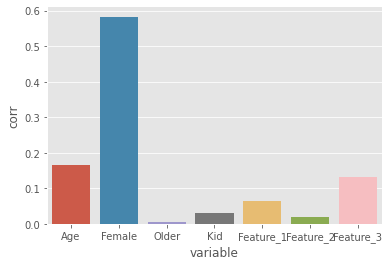

In [ ]:
# 特徴量ごとの重要度 ＝ その特徴量ごとでのジニ係数の減少幅の平均(サンプル数で重み付けされている)
variable_df = x_train.columns
importances_df  = model.feature_importances_ # feature_importances_ ＝ 特徴量の重要度
view_df  = pd.DataFrame({'variable': variable_df, 'corr': importances_df})
view= view_df.sort_values(by='corr', ascending=False)
sns.barplot(x='variable', y='corr', data=view_df)
view_df_1 = cp(view_df)

## XGBoost
公式ドキュメント : https://xgboost.readthedocs.io/en/latest/python/python_api.html  
ここでは簡易紹介するだけ．  
本格的な説明は ドキュメントを参照のこと．  

In [ ]:
# XGBoost のインポートをします
import xgboost as xgb

# データを XGBoost 用のデータマトリックスに変換 
train_data_xgb = xgb.DMatrix(x_train, y_train)
valid_data_xgb = xgb.DMatrix(x_valid, y_valid)

# ハイパーパラメータ設定
xgb_params = {
    'max_depth':3, # 木の深さ
    'learning_rate': 0.05, # 学習率
    'objective':'binary:logistic', 
    }
num_boost_round = 100 # 木の数

# xgb は乱数を使わないっぽい？

# 学習
learning_start_xgb = time.time()
model_xgb = xgb.train(
    params = xgb_params, # パラメータ
    dtrain = train_data_xgb, # 訓練データセット
    num_boost_round=num_boost_round # ラウンド数
    )
learning_end_xgb = time.time()

### モデルの Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

# train データに対する予測
predict_y_train_proba = model_xgb.predict(xgb.DMatrix(x_train))
# 予測は確率で出るので 0.5 以下かそれ以上で 0 or 1 の　2 値に変換 
predict_y_train  = [1 if k>0.5 else 0 for k in predict_y_train_proba]

accuracy_train = accuracy_score(y_train, predict_y_train)
print('Train accyracy: {}'.format(accuracy_train))

# valid データに対する予測
predict_y_valid_proba = model_xgb.predict(xgb.DMatrix(x_valid))
# 予測は確率で出るので 0.5 以下かそれ以上で 0 or 1 の　2 値に変換 
predict_y_valid  = [1 if k>0.5 else 0 for k in predict_y_valid_proba]

accuracy_valid = accuracy_score(y_valid, predict_y_valid)
print('Valid accyracy: {}'.format(accuracy_valid))

Train accyracy: 0.8216292134831461
Valid accyracy: 0.8100558659217877


## 交差検証法

    train-error-mean  train-error-std  test-error-mean  test-error-std
0           0.184923         0.005299         0.195071        0.045605
1           0.184923         0.005299         0.195071        0.045605
2           0.184923         0.005299         0.195071        0.045605
3           0.184923         0.005299         0.195071        0.045605
4           0.184923         0.005299         0.195071        0.045605
..               ...              ...              ...             ...
95          0.176964         0.007560         0.188087        0.035528
96          0.176964         0.007560         0.188087        0.035528
97          0.176964         0.007560         0.188087        0.035528
98          0.176964         0.007560         0.188087        0.035528
99          0.177120         0.007463         0.186679        0.035418

[100 rows x 4 columns]


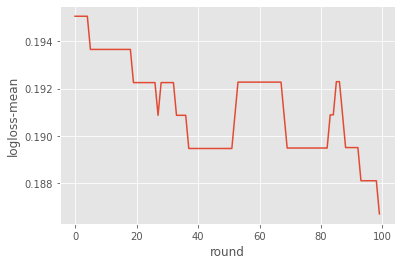

In [ ]:
params = {}
num_round = 100

cv_results = xgb.cv(params=xgb_params, dtrain=train_data_xgb, num_boost_round=num_round, nfold=10, seed=0)
print(cv_results)

cv_mean = cv_results['test-error-mean']
round_n = np.arange(len(cv_mean))

plt.xlabel('round')
plt.ylabel('logloss-mean')
plt.plot(round_n, cv_mean)
plt.show()

## 決定木の構造の可視化

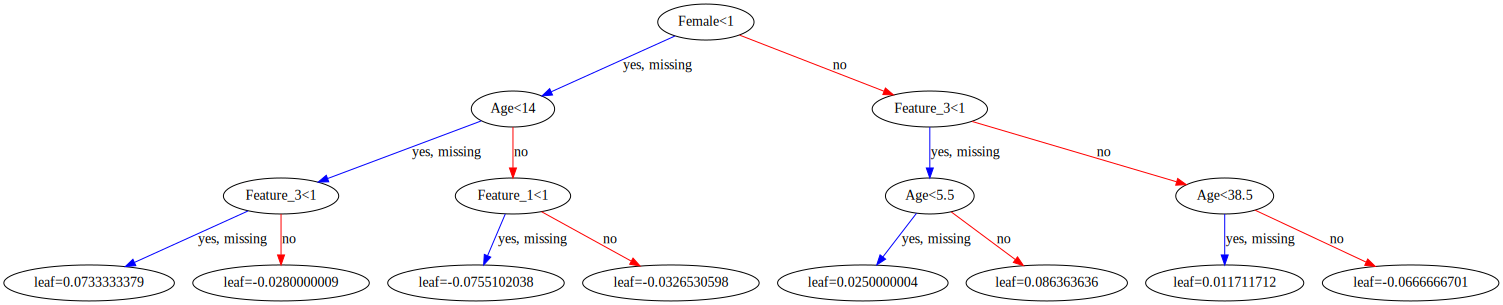

In [ ]:
# 表示する木の番号の指定
i = 0 
xgb.to_graphviz(model_xgb, num_trees=i)

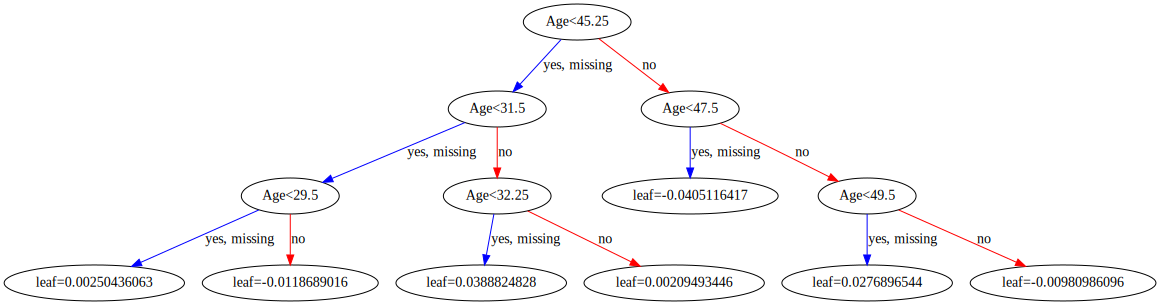

In [ ]:
# 表示する木の番号の指定
i = 99 
xgb.to_graphviz(model_xgb, num_trees=i)

## XGBoost の特徴量の重要度の可視化

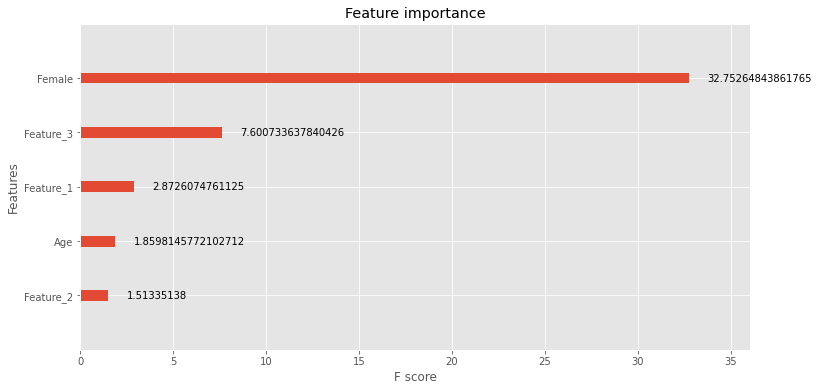

In [ ]:
from matplotlib import pyplot as plt

_, ax = plt.subplots(figsize=(12, 6))
xgb.plot_importance(model_xgb, ax=ax, importance_type='gain')
plt.show()

## LightGBM  
公式ドキュメント : https://lightgbm.readthedocs.io/en/latest/

In [ ]:
# lightgbm のパッケージを import 
import lightgbm as lgb

# データを LightGBM 用のデータマトリックスに変換 
train_data_lgbm = lgb.Dataset(x_train, y_train)
valid_data_lgbm = lgb.Dataset(x_valid, y_valid)


# ハイパーパラメータ設定
# 参考: https://lightgbm.readthedocs.io/en/latest/Parameters.html
lgbm_params = {
    'task': 'train',
    'application': 'binary',     # 2クラス問題
    'boosting': 'gbdt',
#     'boosting': 'rf',
#     'boosting': 'dart',          # dart (drop out trees)
#     'drop_rate': 0.1,
    'max_depth': 3, # 木の深さ
    'num_leaves': 41,
    'learning_rate': 0.05, # 学習率
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'min_data_in_leaf': 10,
    'metric': 'binary_logloss', 
#     'metric': 'l1',
#     'metric': 'l2',
#     'metric': 'AUC', 
#     'verbose': 0,
    'seed': 0, # 乱数はシード 0 に固定
}
num_boost_round=100 # 木の数
early_stopping_rounds=10

# 学習
learning_start_lgbm = time.time()
# model_lgbm = lgb.train(train_set=train_data_lgbm, params=lgbm_params)
model_lgbm = lgb.train(train_set=train_data_lgbm, params=lgbm_params, valid_sets=valid_data_lgbm, num_boost_round=num_boost_round)
# model_lgbm = lgb.train(train_set=train_data_lgbm, params=lgbm_params, valid_sets=valid_data_lgbm, num_boost_round=num_boost_round, early_stopping_rounds=early_stopping_rounds)
learning_end_lgbm = time.time()

[1]	valid_0's binary_logloss: 0.659337
[2]	valid_0's binary_logloss: 0.640207
[3]	valid_0's binary_logloss: 0.634843
[4]	valid_0's binary_logloss: 0.616021
[5]	valid_0's binary_logloss: 0.600996
[6]	valid_0's binary_logloss: 0.595269
[7]	valid_0's binary_logloss: 0.580261
[8]	valid_0's binary_logloss: 0.576404
[9]	valid_0's binary_logloss: 0.564046
[10]	valid_0's binary_logloss: 0.560906
[11]	valid_0's binary_logloss: 0.548643
[12]	valid_0's binary_logloss: 0.544515
[13]	valid_0's binary_logloss: 0.534901
[14]	valid_0's binary_logloss: 0.531367
[15]	valid_0's binary_logloss: 0.522007
[16]	valid_0's binary_logloss: 0.514569
[17]	valid_0's binary_logloss: 0.511229
[18]	valid_0's binary_logloss: 0.503515
[19]	valid_0's binary_logloss: 0.496442
[20]	valid_0's binary_logloss: 0.490235
[21]	valid_0's binary_logloss: 0.483822
[22]	valid_0's binary_logloss: 0.481432
[23]	valid_0's binary_logloss: 0.478837
[24]	valid_0's binary_logloss: 0.474041
[25]	valid_0's binary_logloss: 0.46895
[26]	valid

### モデルの Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

# train データに対する予測
predict_y_train_proba = model_lgbm.predict(x_train, num_iteration=model_lgbm.best_iteration)
# 予測は確率で出るので 0.5 以下かそれ以上で 0 or 1 の　2 値に変換 
predict_y_train  = [1 if k>0.5 else 0 for k in predict_y_train_proba]

accuracy_train = accuracy_score(y_train, predict_y_train)
print('Train accyracy: {}'.format(accuracy_train))

# valid データに対する予測
predict_y_valid_proba = model_lgbm.predict(x_valid, num_iteration=model_lgbm.best_iteration)
# 予測は確率で出るので 0.5 以下かそれ以上で 0 or 1 の　2 値に変換 
predict_y_valid  = [1 if k>0.5 else 0 for k in predict_y_valid_proba]

accuracy_valid = accuracy_score(y_valid, predict_y_valid)
print('Valid accyracy: {}'.format(accuracy_valid))

Train accyracy: 0.8216292134831461
Valid accyracy: 0.8156424581005587


## 交差検証（Cross-validation）

dict_keys(['binary_logloss-mean', 'binary_logloss-stdv'])


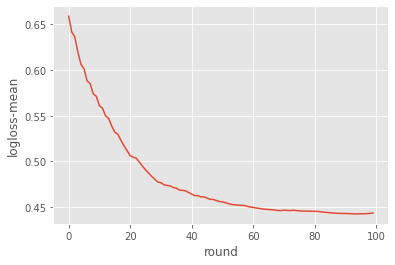

Cross-Validation Average loss: 0.4433664239848438


In [ ]:
cv_results = lgb.cv(lgbm_params, train_data_lgbm, nfold=10)
print(cv_results.keys())
cv_mean = cv_results['binary_logloss-mean']
round_n = np.arange(len(cv_mean))

plt.xlabel('round')
plt.ylabel('logloss-mean')
plt.plot(round_n, cv_mean)
plt.show()

# スコアの平均値
print('Cross-Validation Average loss: {}'.format(np.mean(cv_mean[-1]))) # Accuracy ではなく loss (binary_logloss) なのに注意

## 決定木の構造の可視化

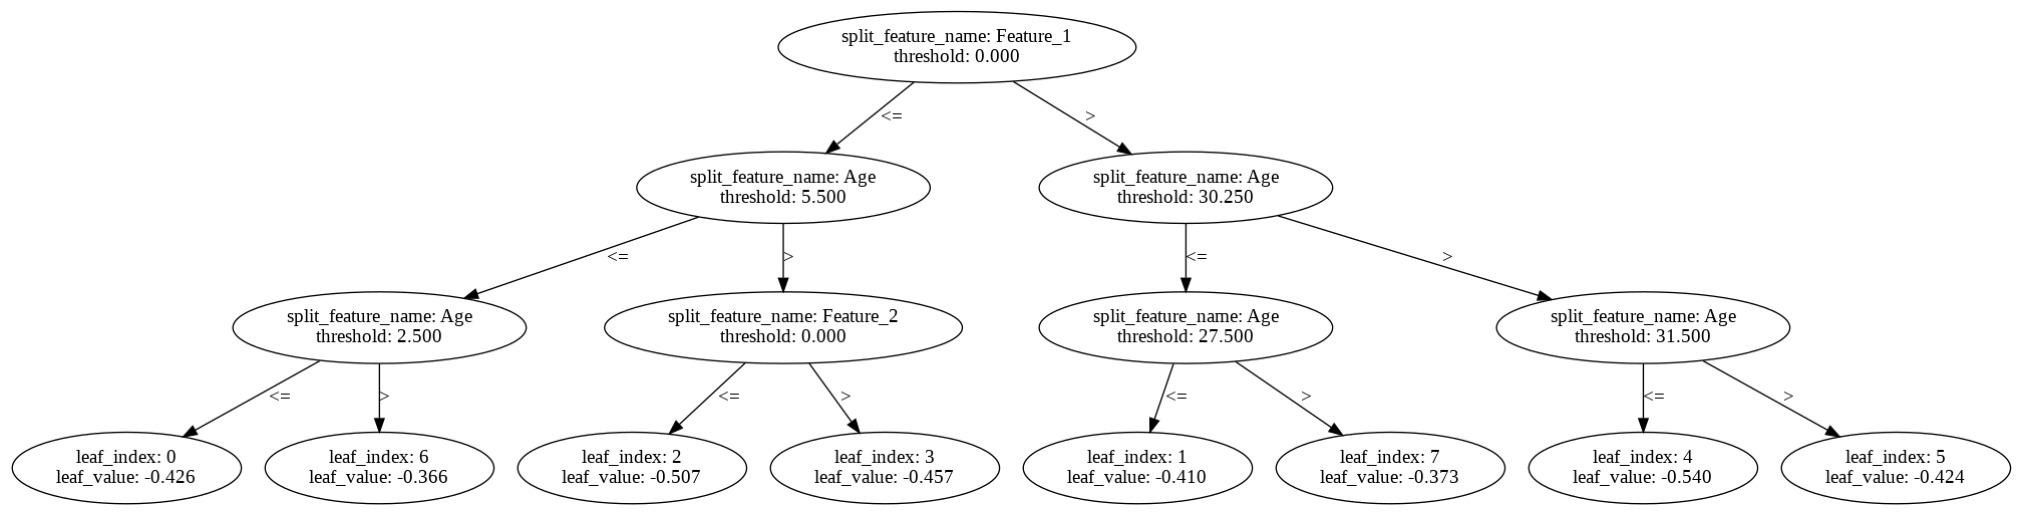

In [ ]:
# 表示する木の番号の指定
i = 0 
lgb.plot_tree(model_lgbm, figsize=(36, 36), precision=3, tree_index=i)

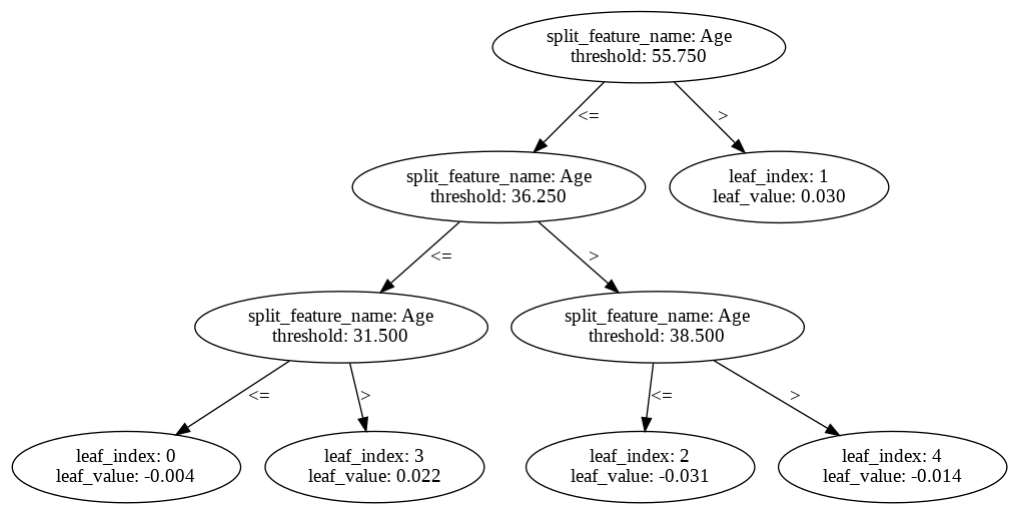

In [ ]:
# 表示する木の番号の指定
i = 99 
lgb.plot_tree(model_lgbm, figsize=(18, 18), precision=3, tree_index=i)

## LightGBMの特徴量の重要度の可視化

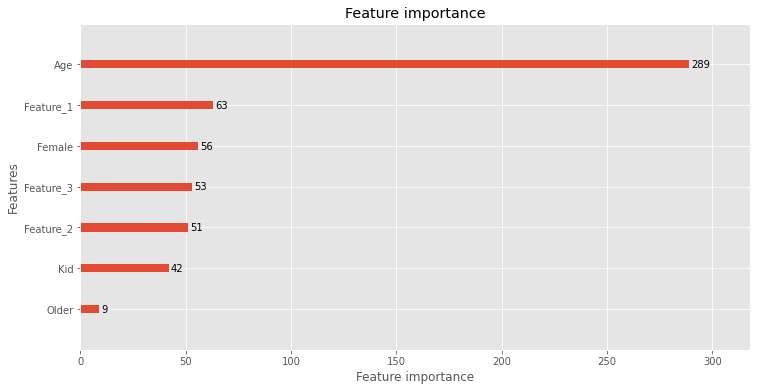

In [ ]:
from matplotlib import pyplot as plt

lgb.plot_importance(model_lgbm, figsize=(12, 6))
plt.show()

## 実行時間比較

In [ ]:
print('sklearn learning time: {}'.format(learning_end - learning_start))
print('XGBoost learning time: {}'.format(learning_end_xgb - learning_start_xgb))
print('LightGBM learning time: {}'.format(learning_end_lgbm - learning_start_lgbm))

sklearn learning time: 0.07855463027954102
XGBoost learning time: 0.13320374488830566
LightGBM learning time: 0.14511489868164062


# コメント
完全に同じ条件で回している訳ではないがので当てにならないが XGBoost 今回はが一番速くなっている  
その代わり精度も一番悪い
(XGBoost のパラメータが適当なのもあるかも？)  
おそらくもっとデータ数が増えると差が出てくる  

## 課題 1
好きな勾配ブースティングのパッケージを使い，好きなハイパーパラメータ(木の深さなど)で，好きな特徴量を使ってなるべく高い valid accuracy  を目指す   
valid accuracy が 0.818 を超えていれば合格  
それ以上は高いごとにプラス加点  
※以下はたまたま lightGBM を使っているだけなので変えて良い

In [ ]:
# ここではデータフレームを一時保存から読み込んでいる
# 変更可能
# セルを追加して特徴量を追加するのも OK
all_train_df_ = cp(all_train_df_tmp)
test_df_ = cp(test_df_tmp)

## validation data に分割

In [ ]:
# 訓練データと valid データの分割
train_df, valid_df = train_test_split(all_train_df_, test_size=0.2, random_state=0) # 乱数シードを固定して train をさらに test と valid data を 8:2 で分割

## 教師信号と入力データを用意

In [ ]:
# 訓練データ準備
x_train = train_df.drop(['PassengerId','Survived','Pclass','Sex', 'Name','SibSp','Parch','Ticket','Fare','Cabin','Embarked'],axis=1) # 教師信号(Survived) 含めて必要ないデータを落とす
y_train = train_df.Survived
# Valid データ準備
x_valid = valid_df.drop(['PassengerId','Survived','Pclass','Sex', 'Name','SibSp','Parch','Ticket','Fare','Cabin','Embarked'],axis=1) # 教師信号(Survived) 含めて必要ないデータを落とす
y_valid = valid_df.Survived

## モデルの学習
好きな物を使って良い  

In [ ]:
# lightgbm のパッケージを import 
import lightgbm as lgb

# データを LightGBM 用のデータマトリックスに変換 
train_data_lgbm = lgb.Dataset(x_train, y_train)
valid_data_lgbm = lgb.Dataset(x_valid, y_valid)


# ハイパーパラメータ設定
# 参考: https://lightgbm.readthedocs.io/en/latest/Parameters.html
lgbm_params = {
    'task': 'train',
    'application': 'binary',     # 2クラス問題
    'boosting': 'gbdt',
#     'boosting': 'rf',
#     'boosting': 'dart',          # dart (drop out trees)
#     'drop_rate': 0.1,
    'max_depth': 10,
    'num_leaves': 41,
    'learning_rate': 0.05,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'min_data_in_leaf': 10,
    'metric': 'binary_logloss', 
#     'metric': 'l1',
#     'metric': 'l2',
#     'metric': 'AUC', 
#     'verbose': 0,
    'seed': 1,
}
num_boost_round=100
early_stopping_rounds=10

# 学習
# model_lgbm2 = lgb.train(train_set=train_data_lgbm, params=lgbm_params)
model_lgbm2 = lgb.train(train_set=train_data_lgbm, params=lgbm_params, valid_sets=valid_data_lgbm, num_boost_round=num_boost_round)
# model_lgbm2 = lgb.train(train_set=train_data_lgbm, params=lgbm_params, valid_sets=valid_data_lgbm, num_boost_round=num_boost_round, early_stopping_rounds=early_stopping_rounds)

[1]	valid_0's binary_logloss: 0.64502
[2]	valid_0's binary_logloss: 0.625606
[3]	valid_0's binary_logloss: 0.608804
[4]	valid_0's binary_logloss: 0.592909
[5]	valid_0's binary_logloss: 0.586886
[6]	valid_0's binary_logloss: 0.573498
[7]	valid_0's binary_logloss: 0.561283
[8]	valid_0's binary_logloss: 0.549835
[9]	valid_0's binary_logloss: 0.5403
[10]	valid_0's binary_logloss: 0.532856
[11]	valid_0's binary_logloss: 0.528344
[12]	valid_0's binary_logloss: 0.518756
[13]	valid_0's binary_logloss: 0.510084
[14]	valid_0's binary_logloss: 0.502371
[15]	valid_0's binary_logloss: 0.496342
[16]	valid_0's binary_logloss: 0.489358
[17]	valid_0's binary_logloss: 0.486175
[18]	valid_0's binary_logloss: 0.480024
[19]	valid_0's binary_logloss: 0.473736
[20]	valid_0's binary_logloss: 0.468965
[21]	valid_0's binary_logloss: 0.463864
[22]	valid_0's binary_logloss: 0.461528
[23]	valid_0's binary_logloss: 0.460674
[24]	valid_0's binary_logloss: 0.458756
[25]	valid_0's binary_logloss: 0.45461
[26]	valid_0'

### モデルの Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

# train データに対する予測
predict_y_train_proba = model_lgbm2.predict(x_train, num_iteration=model_lgbm2.best_iteration)
# 予測は確率で出るので 0.5 以下かそれ以上で 0 or 1 の　2 値に変換 
predict_y_train  = [1 if k>0.5 else 0 for k in predict_y_train_proba]

accuracy_train = accuracy_score(y_train, predict_y_train)
print('Train accyracy: {}'.format(accuracy_train))

# valid データに対する予測
predict_y_valid_proba = model_lgbm2.predict(x_valid, num_iteration=model_lgbm2.best_iteration)
# 予測は確率で出るので 0.5 以下かそれ以上で 0 or 1 の　2 値に変換 
predict_y_valid  = [1 if k>0.5 else 0 for k in predict_y_valid_proba]

accuracy_valid = accuracy_score(y_valid, predict_y_valid)
print('Valid accyracy: {}'.format(accuracy_valid))

Train accyracy: 0.8469101123595506
Valid accyracy: 0.8547486033519553


## 交差検証（Cross-validation）

dict_keys(['binary_logloss-mean', 'binary_logloss-stdv'])


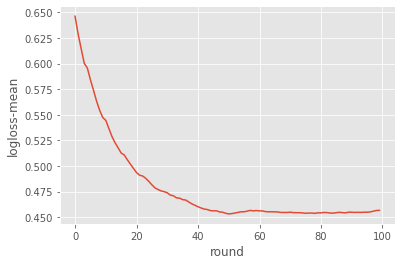

Cross-Validation Average loss: 0.4566719692496606


In [ ]:
cv_results2 = lgb.cv(lgbm_params, train_data_lgbm, nfold=10)
print(cv_results2.keys())
# cv_ = cv_results2['auc-mean']
cv_mean2 = cv_results2['binary_logloss-mean']
round_n = np.arange(len(cv_mean2))

plt.xlabel('round')
plt.ylabel('logloss-mean')
plt.plot(round_n, cv_mean2)
plt.show()

# スコアの平均値
print('Cross-Validation Average loss: {}'.format(np.mean(cv_mean2[-1]))) # Accuracy ではなく loss (binary_logloss) なのに注意

## 決定木の構造の可視化

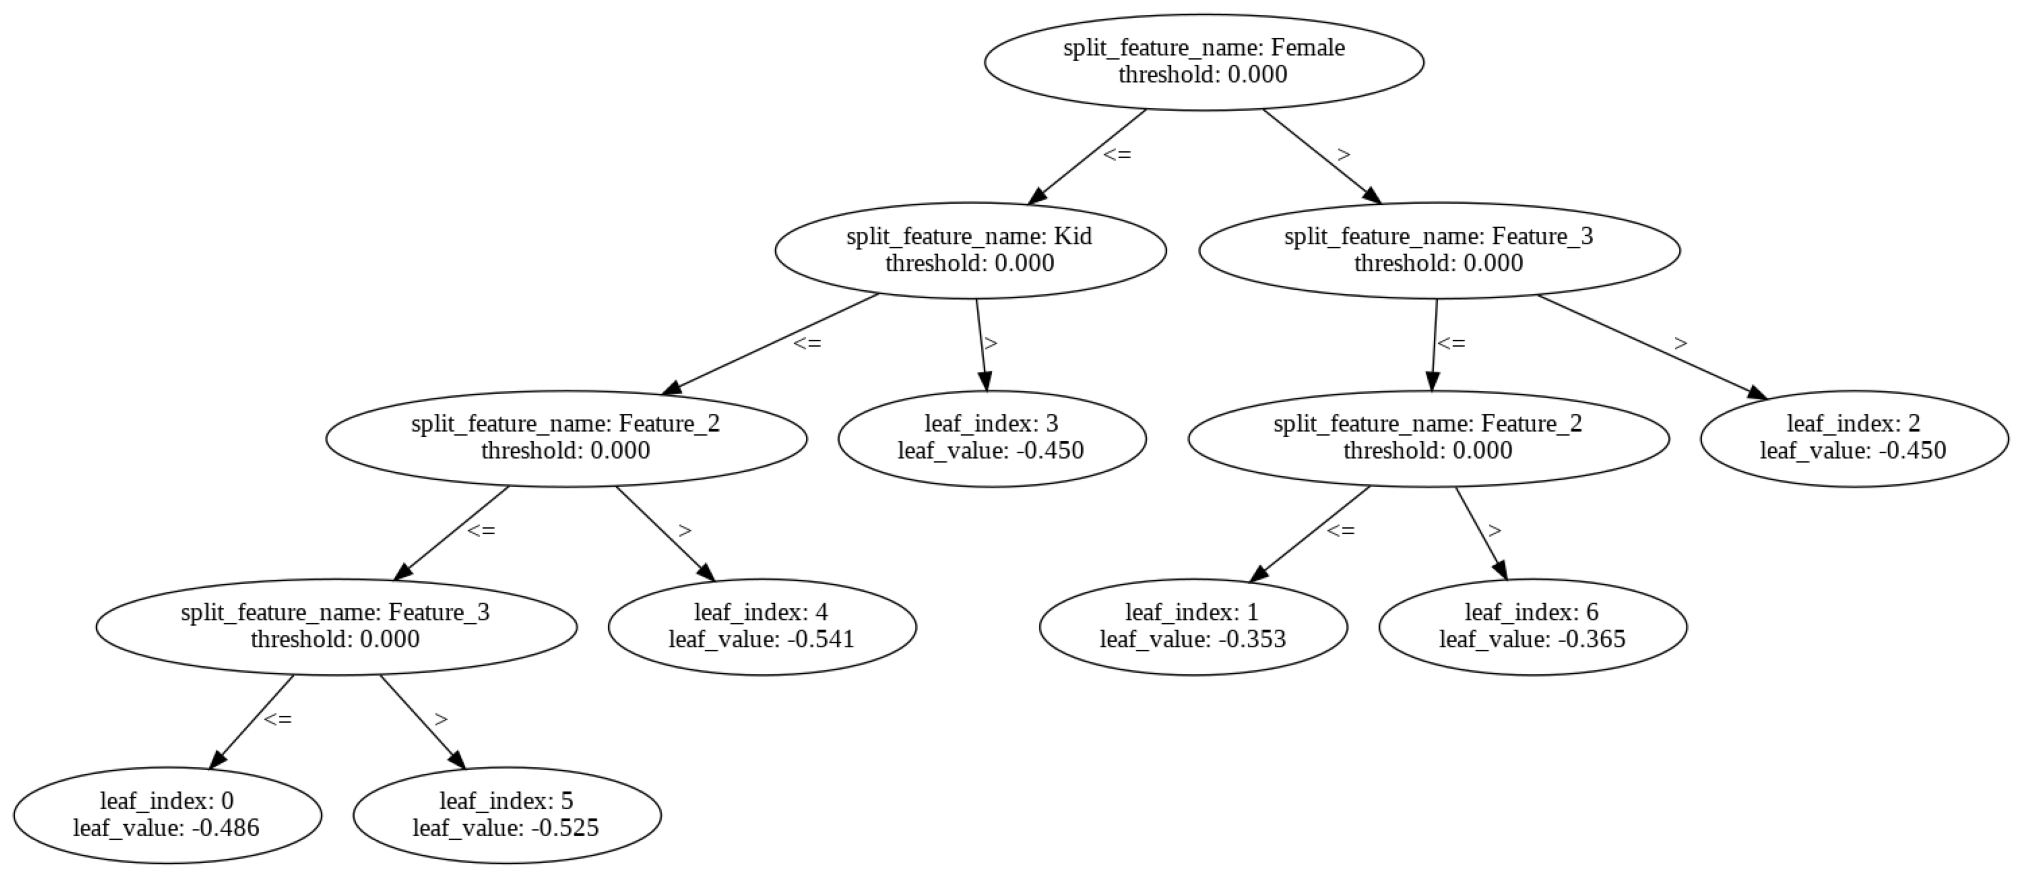

In [ ]:
# 表示する木の番号の指定
i = 0 
lgb.plot_tree(model_lgbm2, figsize=(36, 36), precision=3, tree_index=i)

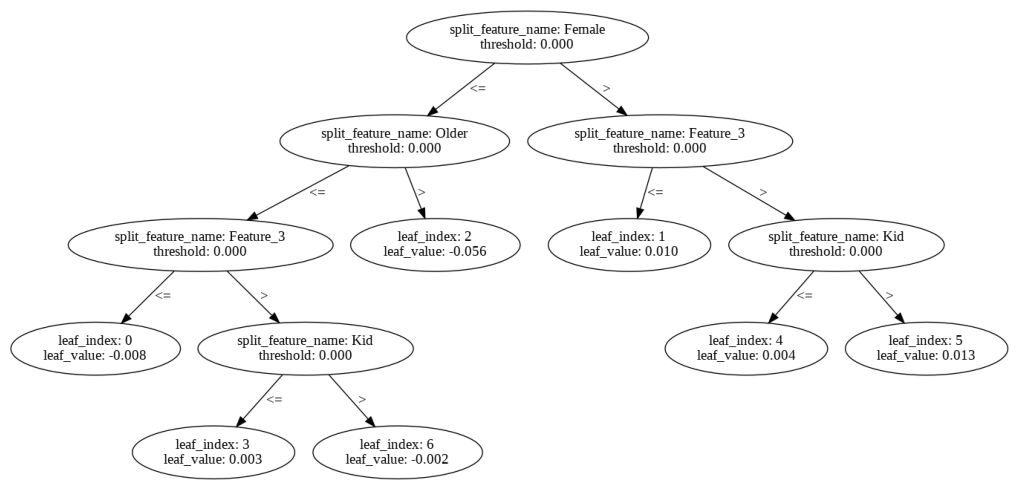

In [ ]:
# 表示する木の番号の指定
i = 99 
lgb.plot_tree(model_lgbm2, figsize=(18, 18), precision=3, tree_index=i)

## LightGBMの特徴量の重要度の可視化

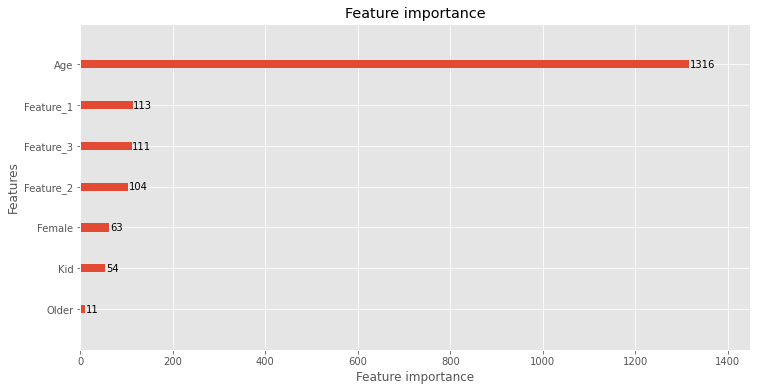

In [ ]:
from matplotlib import pyplot as plt

lgb.plot_importance(model_lgbm2, figsize=(12, 6))
plt.show()